In [100]:
# Importing necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import csv

# Vox Converse Mel Dataset

In [101]:
class VoxConverseMelDataset(Dataset):
    def __init__(self, split="dev", sample_rate=16000, n_mels=80):
        self.ds = load_dataset("diarizers-community/voxconverse", split=split)
        self.sr = sample_rate
        self.mel = torch.nn.Sequential(
            T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels),
            T.AmplitudeToDB()
        )

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        s = self.ds[idx]
        # Convert to float32 to match the expected type for MelSpectrogram
        wav = torch.tensor(s["audio"]["array"], dtype=torch.float32).unsqueeze(0)
        sr = s["audio"]["sampling_rate"]
        if sr != self.sr:
            wav = T.Resample(sr, self.sr)(wav)
            
        # Handle large files with chunking if needed
        max_length = 60 * self.sr  # Limit to 60 seconds
        if wav.shape[1] > max_length:
            # Take first chunk only
            wav = wav[:, :max_length]
            
        mel = self.mel(wav).squeeze(0)
        
        # Downsample mel spectrogram if too large
        if mel.shape[1] > 3000:  # If more than 3000 time frames
            stride = mel.shape[1] // 3000 + 1
            mel = mel[:, ::stride]
            
        return {"log_mel": mel, "start_times": s["timestamps_start"], "end_times": s["timestamps_end"], "speakers": s["speakers"]}

In [102]:
def pad_collate_fn(batch):
    max_len = max(x['log_mel'].shape[1] for x in batch)
    padded = [F.pad(x['log_mel'], (0, max_len - x['log_mel'].shape[1])) for x in batch]
    return {
        "log_mel": torch.stack(padded),
        "start_times": [x['start_times'] for x in batch],
        "end_times": [x['end_times'] for x in batch],
        "speakers": [x['speakers'] for x in batch]
    }

In [113]:
def generate_activity_matrix(batch, sr=16000, hop=160, max_spks=8):
    B, _, T = batch['log_mel'].shape
    targets = torch.zeros((B, max_spks, T), dtype=torch.float32)  # Explicitly set type
    
    for b in range(B):
        spks = batch['speakers'][b]
        
        # Limit number of speakers if too many
        unique_spks = sorted(set(spks))
        if len(unique_spks) > max_spks:
            unique_spks = unique_spks[:max_spks]
            
        spk_map = {spk: i for i, spk in enumerate(unique_spks)}
        
        mel_length = T
        for s, e, spk in zip(batch['start_times'][b], batch['end_times'][b], spks):
            if spk not in spk_map:
                continue
                
            i = spk_map[spk]
            # Convert time to frame index
            sf, ef = int(s * sr / hop), min(int(e * sr / hop), mel_length)
            
            # Skip if outside bounds or invalid
            if sf >= mel_length or ef <= 0 or sf >= ef:
                continue
                
            targets[b, i, sf:ef] = 1.0
            
    return targets

# Embedding Model

In [114]:
# -------- Blocks (SE, Res2Net, etc.) -------- #
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1)

    def forward(self, x):
        z = F.adaptive_avg_pool1d(x, 1)
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return x * z

In [115]:
# Res2Net-style bottleneck block
class Res2Block(nn.Module):
    def __init__(self, channels, scale=8):
        super().__init__()
        assert channels % scale == 0
        self.scale = scale
        self.width = channels // scale
        self.convs = nn.ModuleList([
            nn.Conv1d(self.width, self.width, kernel_size=3, padding=1)
            for _ in range(scale - 1)
        ])

    def forward(self, x):
        splits = torch.split(x, self.width, dim=1)
        out = [splits[0]]
        for i in range(1, self.scale):
            out.append(self.convs[i - 1](out[-1] + splits[i]))
        return torch.cat(out, dim=1)

In [116]:
# TDNN + ECAPA block
class ECAPA_TDNN_Block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.tdnn = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.res2 = Res2Block(channels)
        self.se = SEBlock(channels)

    def forward(self, x):
        out = self.tdnn(x)
        out = F.relu(self.res2(out))
        out = self.se(out)
        return out + x

In [117]:
# Attentive Statistics Pooling
class AttentiveStatsPool(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        h = torch.tanh(self.linear(x))
        w = torch.softmax(self.attention(h), dim=1)
        mean = torch.sum(w * x, dim=1)
        std = torch.sqrt(torch.sum(w * (x - mean.unsqueeze(1))**2, dim=1) + 1e-9)
        return torch.cat([mean, std], dim=1)

In [118]:
# ECAPA-TDNN Encoder
class ECAPA_TDNN_Encoder(nn.Module):
    def __init__(self, input_dim=80, channels=512, emb_dim=192):
        super().__init__()
        self.initial = nn.Conv1d(input_dim, channels, kernel_size=5, padding=2)
        self.blocks = nn.Sequential(
            ECAPA_TDNN_Block(channels),
            ECAPA_TDNN_Block(channels),
            ECAPA_TDNN_Block(channels)
        )
        self.mfa = nn.Conv1d(channels * 3, channels, kernel_size=1)
        self.pooling = AttentiveStatsPool(channels, 128)
        self.fc = nn.Linear(channels * 2, emb_dim)

    def forward(self, x):
        x = self.initial(x)
        out1 = self.blocks[0](x)
        out2 = self.blocks[1](out1)
        out3 = self.blocks[2](out2)
        x_cat = torch.cat([out1, out2, out3], dim=1)
        x_fused = self.mfa(x_cat)
        pooled = self.pooling(x_fused)
        embedding = self.fc(pooled)
        return embedding, x_fused

# Speech Diarization Model

In [119]:
class Combiner(nn.Module):
    def __init__(self, D, S, alpha=10):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.G = nn.Parameter(torch.randn(1, D, S + 1))

    def forward(self, u_cap):
        B = u_cap.shape[0]
        G_expanded = self.G.expand(B, -1, -1)
        u_gate = torch.sigmoid(u_cap).unsqueeze(-1)
        return self.alpha * u_gate * G_expanded

In [120]:
class TransformerDecoder(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, d_ff, num_layers, memory_dim=512):
        super().__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_ff)
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.query_proj = nn.Linear(input_dim, d_model)
        self.memory_proj = nn.Linear(memory_dim, d_model)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, I0, E):
        I0 = self.query_proj(I0.permute(2, 0, 1))
        E = self.memory_proj(E.permute(2, 0, 1))
        out = self.transformer(tgt=I0, memory=E)
        A = self.output_proj(out).permute(1, 2, 0)
        return A

In [121]:
class Speech_Diarization(nn.Module):
    def __init__(self, input_dim=80, channels=256, emb_dim=128, num_heads=4, d_ff=1024, num_layers=3, max_speakers=8):
        super().__init__()
        self.encoder = ECAPA_TDNN_Encoder(input_dim, channels, emb_dim)
        self.combiner = Combiner(emb_dim, max_speakers)  # Use max_speakers here
        self.decoder = TransformerDecoder(emb_dim, emb_dim, num_heads, d_ff, num_layers, memory_dim=channels)
        self.features_proj = nn.Conv1d(channels, emb_dim, kernel_size=1)
        self.max_speakers = max_speakers  # Store this for reference

    def forward(self, x):
        embedding, framewise = self.encoder(x)
        E = self.features_proj(framewise)
        I0 = self.combiner(embedding)
        A = self.decoder(I0, framewise)[:, :, 1:]
        P = torch.einsum('bds,bdt->bst', A, E)
        return torch.sigmoid(P)

# Training

Using GPU: NVIDIA TITAN RTX
Memory allocated: 4138.13 MB
Memory reserved: 4836.00 MB
Max memory allocated: 20287.98 MB
Epoch 1 Loss: 1.4193
Best model updated (epoch 1, loss 1.4193)
Epoch 2 Loss: 0.5190
Best model updated (epoch 2, loss 0.5190)
Epoch 3 Loss: 0.3664
Best model updated (epoch 3, loss 0.3664)
Epoch 4 Loss: 0.3154
Best model updated (epoch 4, loss 0.3154)
Epoch 5 Loss: 0.2717
Best model updated (epoch 5, loss 0.2717)
Epoch 6 Loss: 0.2442
Best model updated (epoch 6, loss 0.2442)
Epoch 7 Loss: 0.2378
Best model updated (epoch 7, loss 0.2378)
Epoch 8 Loss: 0.2265
Best model updated (epoch 8, loss 0.2265)
Epoch 9 Loss: 0.2171
Best model updated (epoch 9, loss 0.2171)
Epoch 10 Loss: 0.2022
Best model updated (epoch 10, loss 0.2022)
Epoch 11 Loss: 0.1930
Best model updated (epoch 11, loss 0.1930)
Epoch 12 Loss: 0.1964
Epoch 13 Loss: 0.1845
Best model updated (epoch 13, loss 0.1845)
Epoch 14 Loss: 0.1786
Best model updated (epoch 14, loss 0.1786)
Epoch 15 Loss: 0.1848
Epoch 16 L

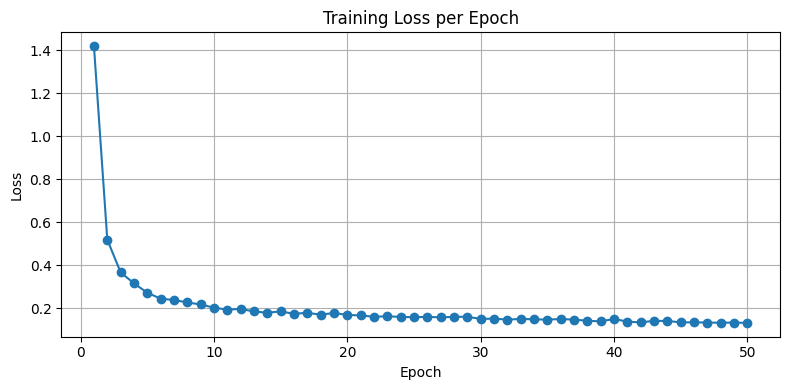

In [123]:
# Memory optimization settings
torch.cuda.empty_cache()

# Consistent max_speakers value across the model
max_speakers = 20

# Try to set memory allocation config if possible
try:
    torch.cuda.set_per_process_memory_fraction(0.7)  # Use only 70% of available GPU memory
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
except:
    print("Could not set memory allocation configuration")

# Reduce model size and batch size
ds = VoxConverseMelDataset()
loader = DataLoader(ds, batch_size=1, shuffle=True, collate_fn=pad_collate_fn)

# Create model with reduced size and consistent max_speakers
model = Speech_Diarization(channels=256, emb_dim=128, num_heads=4, d_ff=1024, num_layers=3, max_speakers=max_speakers)
model.train()

# Check available memory and select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"Max memory allocated: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")
else:
    print("Using CPU")

model.to(device)
opt = opt = optim.Adam(model.parameters(), lr=5e-5)
epoch_loss = []
best_loss = float("inf")
best_model_path = "best_diarization_model.pt"

for epoch in range(50):
    total_loss = 0
    num_batches = 0

    for i, batch in enumerate(loader):
        try:
            # Process in smaller chunks if needed
            x = batch['log_mel'].to(device)
            y = generate_activity_matrix(batch, max_spks=max_speakers).to(device)

            # Ensure shapes match
            pred = model(x)
            if pred.shape != y.shape:
                print(f"Shape mismatch: pred {pred.shape}, target {y.shape}")
                # Adjust target if necessary
                if pred.shape[1] != y.shape[1]:
                    if pred.shape[1] > y.shape[1]:
                        y_padded = torch.zeros_like(pred)
                        y_padded[:, :y.shape[1], :] = y
                        y = y_padded
                    else:
                        y = y[:, :pred.shape[1], :]

            loss = F.binary_cross_entropy(pred, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()

            # Free up memory
            loss_val = loss.item()
            del x, y, pred, loss

            if device.type == 'cuda':
                torch.cuda.empty_cache()

            total_loss += loss_val
            num_batches += 1

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"CUDA OOM in batch {i+1}. Skipping this batch.")
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
                opt.zero_grad()
                continue
            elif "size mismatch" in str(e) or "shape" in str(e).lower():
                print(f"Size mismatch in batch {i+1}: {e}")
                print(f"Skipping problematic batch")
                continue
            else:
                raise e

    if num_batches > 0:
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
        epoch_loss.append(avg_loss)

        # Save best model only
        if avg_loss < best_loss:
            best_loss = avg_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }
            torch.save(checkpoint, best_model_path)
            print(f"Best model updated (epoch {epoch+1}, loss {avg_loss:.4f})")
    else:
        print(f"Epoch {epoch+1}: No valid batches processed")

# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("training_loss_curve.png")
plt.show()

# Optionally save to CSV
with open("training_loss_log.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Loss"])
    for i, l in enumerate(epoch_loss, start=1):
        writer.writerow([i, l])

# Inference

In [136]:
def load_model(checkpoint_path, device=None):
    """
    Load a pre-trained speech diarization model.
    
    Args:
        checkpoint_path: Path to the model checkpoint file
        device: The device to load the model onto
        
    Returns:
        The loaded model on the specified device
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model with the same parameters as during training
    model = Speech_Diarization(channels=256, emb_dim=128, num_heads=4, 
                              d_ff=1024, num_layers=3, max_speakers=20)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.to(device)
    model.eval()
    print(f"Model loaded from {checkpoint_path} to {device}")
    return model

In [137]:
def prepare_audio(audio_path, sample_rate=16000, n_mels=80):
    """
    Load and preprocess audio for diarization inference.
    
    Args:
        audio_path: Path to the audio file
        sample_rate: Target sample rate
        n_mels: Number of mel filter banks
        
    Returns:
        Mel spectrogram tensor
    """
    # Load audio file
    print(f"Loading audio from {audio_path}")
    waveform, sr = torchaudio.load(audio_path)
    
    print(f"Audio loaded: {waveform.shape}, Sample rate: {sr}")
    
    # Convert to mono if necessary
    if waveform.shape[0] > 1:
        print("Converting stereo to mono")
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample if necessary
    if sr != sample_rate:
        print(f"Resampling from {sr} to {sample_rate}")
        resampler = T.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Check if audio has valid data
    if torch.max(torch.abs(waveform)) < 1e-5:
        print("WARNING: Audio file seems to be silent or near-silent!")
    
    # Check audio duration
    duration = waveform.shape[1] / sample_rate
    print(f"Audio duration: {duration:.2f} seconds")
    
    # Extract mel spectrogram
    print("Extracting mel spectrogram")
    mel_transform = torch.nn.Sequential(
        T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels),
        T.AmplitudeToDB()
    )
    
    mel = mel_transform(waveform).squeeze(0)
    print(f"Mel spectrogram shape: {mel.shape}")
    
    # Plot mel spectrogram for verification
    plt.figure(figsize=(10, 4))
    plt.imshow(mel.numpy(), aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.savefig('mel_spectrogram_debug.png')
    print("Mel spectrogram visualization saved to mel_spectrogram_debug.png")
    
    # Handle large files with chunking if needed
    max_length = 3000  # Maximum time frames (adjust as needed)
    if mel.shape[1] > max_length:
        print(f"Audio too long. Splitting into chunks.")
        chunks = []
        for i in range(0, mel.shape[1], max_length):
            chunk = mel[:, i:min(i+max_length, mel.shape[1])]
            chunks.append(chunk)
        print(f"Split into {len(chunks)} chunks")
        return chunks
    else:
        return [mel]

In [138]:
def perform_inference(model, mel_chunks, device=None):
    """
    Perform diarization inference on prepared audio chunks.
    
    Args:
        model: Loaded diarization model
        mel_chunks: List of mel spectrogram chunks
        device: Device to run inference on
        
    Returns:
        List of diarization outputs for each chunk
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    results = []
    
    with torch.no_grad():
        for i, mel in enumerate(mel_chunks):
            # Add batch dimension
            mel = mel.unsqueeze(0).to(device)
            print(f"Processing chunk {i+1}/{len(mel_chunks)}, shape: {mel.shape}")
            
            # Forward pass
            try:
                output = model(mel)
                print(f"Output shape: {output.shape}")
                
                # Debug output values
                with torch.no_grad():
                    print(f"Output min: {output.min().item():.4f}, max: {output.max().item():.4f}, mean: {output.mean().item():.4f}")
                    print(f"Values > 0.5: {torch.sum(output > 0.5).item()} out of {output.numel()}")
                    print(f"Values > 0.3: {torch.sum(output > 0.3).item()} out of {output.numel()}")
                    
                    # Check speaker activity
                    speaker_activity = []
                    for spk in range(output.shape[1]):
                        max_prob = output[0, spk].max().item()
                        mean_prob = output[0, spk].mean().item()
                        active_frames = torch.sum(output[0, spk] > 0.3).item()
                        speaker_activity.append((spk, max_prob, mean_prob, active_frames))
                    
                    for spk, max_prob, mean_prob, active_frames in speaker_activity:
                        print(f"Speaker {spk+1}: max={max_prob:.4f}, mean={mean_prob:.4f}, active_frames={active_frames}/{output.shape[2]}")
                
                results.append(output.cpu())
                print(f"Processed chunk {i+1}/{len(mel_chunks)}")
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print(f"CUDA OOM in chunk {i+1}. Trying to process in CPU.")
                    # Try on CPU as fallback
                    model.to('cpu')
                    mel = mel.to('cpu')
                    output = model(mel)
                    results.append(output.cpu())
                    # Move back to GPU if available
                    if torch.cuda.is_available():
                        model.to('cuda')
                else:
                    print(f"Error during inference: {e}")
                    raise e
    
    return results

In [139]:
def extract_speaker_segments(diarization_output, threshold=0.3, hop_length=160, sample_rate=16000, min_duration=0.2):
    """
    Extract segments with lower threshold and shorter minimum duration.
    
    Args:
        diarization_output: Model output tensor or numpy array
        threshold: Activation threshold for speaker detection
        hop_length: Hop length used in the mel spectrogram
        sample_rate: Audio sample rate
        min_duration: Minimum segment duration in seconds
        
    Returns:
        Dictionary mapping speaker IDs to lists of (start_time, end_time) tuples
    """
    # Convert model output to numpy if it's a tensor
    if isinstance(diarization_output, torch.Tensor):
        diar_output = diarization_output.squeeze(0).numpy()
    else:
        diar_output = diarization_output
    
    # Add debugging info
    print(f"Output shape: {diar_output.shape}")
    print(f"Max values per speaker: {np.max(diar_output, axis=1)}")
    print(f"Mean values per speaker: {np.mean(diar_output, axis=1)}")
    print(f"Using threshold: {threshold}")
    
    # Frame to time conversion factor
    frames_to_time = hop_length / sample_rate
    
    speaker_segments = {}
    
    # Process each speaker
    for spk_idx in range(diar_output.shape[0]):
        # Get binary activity mask using threshold
        activity = diar_output[spk_idx] > threshold
        active_frames = np.sum(activity)
        print(f"Speaker {spk_idx+1}: {active_frames} active frames out of {len(activity)}")
        
        if active_frames == 0:
            continue
            
        # Find contiguous segments
        changes = np.diff(activity.astype(int))
        start_frames = np.where(changes == 1)[0] + 1
        end_frames = np.where(changes == -1)[0] + 1
        
        # Handle edge cases
        if activity[0]:
            start_frames = np.insert(start_frames, 0, 0)
        if activity[-1]:
            end_frames = np.append(end_frames, len(activity))
        
        # Convert frames to time and create segments
        segments = []
        for start, end in zip(start_frames, end_frames):
            # Only include segments longer than a minimum duration
            if (end - start) * frames_to_time >= min_duration:
                segments.append((start * frames_to_time, end * frames_to_time))
        
        if segments:
            speaker_segments[f"Speaker {spk_idx+1}"] = segments
    
    return speaker_segments


In [140]:
def visualize_diarization(diarization_outputs, hop_length=160, sample_rate=16000, threshold=0.3):
    """
    Visualize diarization results with threshold line.
    
    Args:
        diarization_outputs: List of model outputs
        hop_length: Hop length used in the mel spectrogram
        sample_rate: Audio sample rate
        threshold: Threshold line to visualize
        
    Returns:
        Figure with visualization
    """
    # Convert model outputs to a single array
    if len(diarization_outputs) == 1:
        # Single chunk case
        diar_output = diarization_outputs[0].squeeze(0).numpy()
    else:
        # Multi-chunk case - concatenate along time dimension
        chunks = [out.squeeze(0).numpy() for out in diarization_outputs]
        diar_output = np.concatenate(chunks, axis=1)
    
    # Create time axis
    frames_to_time = hop_length / sample_rate
    duration = diar_output.shape[1] * frames_to_time
    time_axis = np.linspace(0, duration, diar_output.shape[1])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot each speaker
    for i in range(diar_output.shape[0]):
        ax.plot(time_axis, diar_output[i], label=f"Speaker {i+1}")
    
    # Add threshold line
    ax.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold ({threshold})")
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Speech Probability")
    ax.set_title("Speaker Diarization")
    ax.legend()
    ax.grid(True)
    
    return fig

In [141]:
def try_different_thresholds(diarization_output):
    """Try different thresholds and see how many segments are detected"""
    thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
    
    for threshold in thresholds:
        print(f"\nTrying threshold: {threshold}")
        speaker_segments = extract_speaker_segments(diarization_output, threshold=threshold, min_duration=0.1)
        
        if not speaker_segments:
            print(f"No segments detected with threshold {threshold}")
        else:
            print(f"Detected {len(speaker_segments)} speakers with threshold {threshold}")
            total_segments = sum(len(segs) for segs in speaker_segments.values())
            print(f"Total segments: {total_segments}")
            
            for speaker, segments in speaker_segments.items():
                print(f"  {speaker}: {len(segments)} segments")
    
    return speaker_segments

Using device: cuda
Model loaded from best_diarization_model.pt to cuda
Loading audio from parliament_debate.wav
Audio loaded: torch.Size([1, 19201024]), Sample rate: 16000
Audio duration: 1200.06 seconds
Extracting mel spectrogram
Mel spectrogram shape: torch.Size([80, 96006])
Mel spectrogram visualization saved to mel_spectrogram_debug.png
Audio too long. Splitting into chunks.
Split into 33 chunks
Audio split into 33 chunks
Processing chunk 1/33, shape: torch.Size([1, 80, 3000])
Output shape: torch.Size([1, 20, 3000])
Output min: 0.0000, max: 0.4158, mean: 0.0232
Values > 0.5: 0 out of 60000
Values > 0.3: 531 out of 60000
Speaker 1: max=0.4158, mean=0.2638, active_frames=529/3000
Speaker 2: max=0.3056, mean=0.1621, active_frames=2/3000
Speaker 3: max=0.0621, mean=0.0050, active_frames=0/3000
Speaker 4: max=0.1348, mean=0.0324, active_frames=0/3000
Speaker 5: max=0.0151, mean=0.0006, active_frames=0/3000
Speaker 6: max=0.0022, mean=0.0000, active_frames=0/3000
Speaker 7: max=0.0005, m

/tmp/ipykernel_46253/946113557.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f"{output_dir}/diarization_plot.png")


Visualization saved to diarization_results/diarization_plot.png


([tensor([[[1.6137e-01, 3.5387e-02, 1.0331e-01,  ..., 2.6571e-01,
            2.7304e-01, 3.7082e-01],
           [4.0195e-02, 1.3324e-02, 3.0982e-02,  ..., 1.7742e-01,
            1.8071e-01, 2.9703e-01],
           [1.9538e-07, 2.0451e-06, 9.9115e-07,  ..., 3.4262e-03,
            2.5517e-03, 4.1573e-02],
           ...,
           [6.0141e-24, 2.0419e-19, 1.3562e-22,  ..., 1.5311e-09,
            2.0032e-09, 2.8250e-05],
           [3.8832e-24, 1.5604e-19, 6.9577e-23,  ..., 1.1250e-09,
            1.6232e-09, 2.4579e-05],
           [1.6312e-24, 4.5209e-20, 2.2776e-23,  ..., 6.8449e-10,
            1.5050e-09, 2.4679e-05]]]),
  tensor([[[3.2168e-01, 2.1187e-01, 3.2057e-01,  ..., 2.9316e-01,
            3.4665e-01, 4.1807e-01],
           [1.9859e-01, 1.4522e-01, 1.8030e-01,  ..., 1.8732e-01,
            2.0276e-01, 3.0133e-01],
           [8.2389e-04, 1.4089e-03, 8.9818e-04,  ..., 1.5517e-03,
            2.1494e-03, 2.0892e-02],
           ...,
           [2.5880e-11, 4.5115e-10, 2.

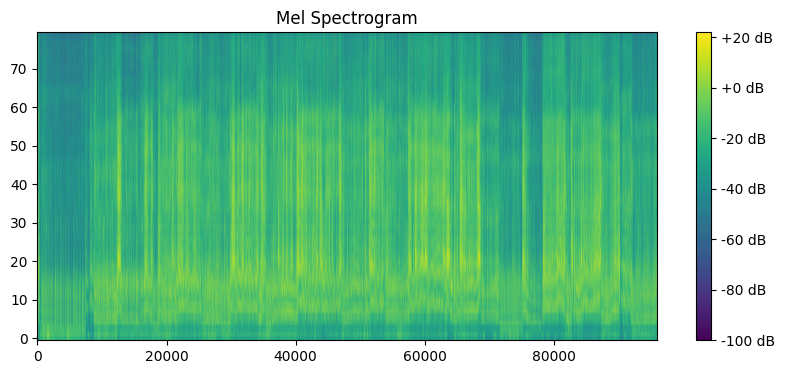

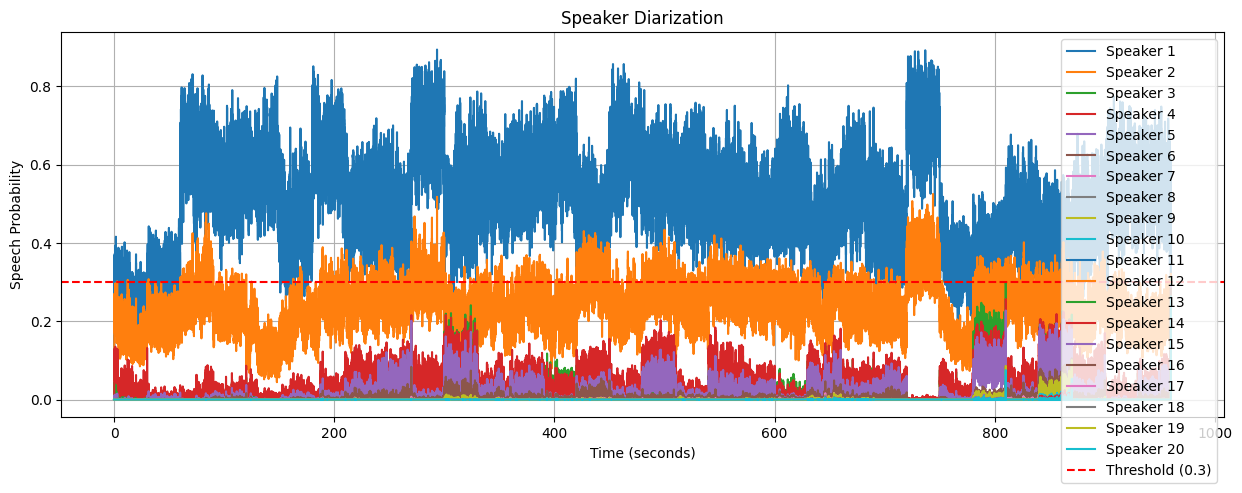

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

checkpoint_path = "best_diarization_model.pt"
audio_path = "parliament_debate.wav"
threshold = 0.3
output_dir = "diarization_results"

# Load model
model = load_model(checkpoint_path, device)

# Prepare audio
mel_chunks = prepare_audio(audio_path)
print(f"Audio split into {len(mel_chunks)} chunks")

# Perform inference
diarization_outputs = perform_inference(model, mel_chunks, device)

# Try different thresholds
print("\nTrying different thresholds to find optimal segmentation:")
segments = try_different_thresholds(diarization_outputs[0])

# Visualize results with threshold line
fig = visualize_diarization(diarization_outputs, threshold=threshold)

# Save visualization
if output_dir:
    fig.savefig(f"{output_dir}/diarization_plot.png")
    print(f"Visualization saved to {output_dir}/diarization_plot.png")
else:
    fig.savefig(f"diarization_plot.png")
    print(f"Visualization saved to diarization_plot.png")

diarization_outputs, segments, fig